In [89]:
import pandas as pd
import pickle
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import eli5
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score,TimeSeriesSplit
import warnings
from IPython.display import display_html
import matplotlib.pyplot as plt

In [203]:
def site_sparse_matrix(path_to_train, path_to_test, pickle_file, vector_params):
    
    # all site columns
    sites = ['site%d' %i for i in range(1,11)]
    times = ['time%d' %i for i in range(1,11)]
    
    train_df = pd.read_csv(path_to_train, index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test, index_col='session_id', parse_dates=times)
    
    train_df = train_df.sort_values(by='time1')
    # clean data 
    train_df[sites] = train_df[sites].fillna(0).astype('int')
    test_df[sites] = test_df[sites].fillna(0).astype('int')

    
    with open(pickle_file,'rb') as input_file:
        site_id_dict = pickle.load(input_file)
    
    site_map={}
    for _name in site_id_dict:
        site_map[site_id_dict[_name]] = _name
    
    site_map[0]='unknown'

    #convert site id -> site name
    # it will help us to analysis after EDA
    # pd.dataframe .apply (axis=1) mean process each row
    train_session = train_df[sites].apply(lambda row: ' '.join([site_map[i] for i in row]), axis=1).tolist()
    test_session = test_df[sites].apply(lambda row: ' '.join([site_map[i] for i in row]), axis=1).tolist()
    
    # have word list now process bag of word 
    vectorizer = TfidfVectorizer(**vector_params)
    X_train = vectorizer.fit_transform(train_session)
    X_test = vectorizer.transform(test_session)
    y_train = train_df['target'].astype('int').values
    train_times = train_df[times]
    test_times = test_df[times]
    
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
    
    

In [204]:
def train_and_predict(model, X_train, y_train, X_test, site_features=tfv.get_feature_names(), new_feature_names=None,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission.csv'):
    
    cv_score = cross_val_score(model, X_train, y_train, cv=time_split, scoring=scoring, n_jobs=-1)
    print('CV ROC Score->{} \r mean: {}, std: {}'.format(cv_score,np.mean(cv_score), np.std(cv_score)))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_features + new_feature_names
    else:
        all_feature_names = site_features
    
    display_html(eli5.show_weights(estimator=model, feature_names=all_feature_names, top=top_n_features))
    
    test_pred = model.predict_proba(X_test)[:,-1]
    write_to_submission_file(test_pred, out_file=submission_file)
    
    return cv_score

In [205]:
# prepare site sparse matrix
train_session, test_session, y_train, tfv, train_times, test_times = site_sparse_matrix('train_sessions.csv','test_sessions.csv','site_dic.pkl',
                                                                                       vector_params={'ngram_range':(1,5),'max_features':50000,'tokenizer':lambda s: s.split(" ")})             

In [7]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score,TimeSeriesSplit

logit = LogisticRegression(C=1.0, random_state=17, solver='liblinear', max_iter=100, n_jobs=-1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
time_split = TimeSeriesSplit(n_splits=10)
cv_scores1 = cross_val_score(logit, train_session, y_train, cv=skf, 
                            scoring='roc_auc', n_jobs=4)
print(cv_scores1)
logit.fit(train_session, y_train)
eli5.show_weights(estimator=logit, feature_names=tfv.get_feature_names(), top=30)

[0.95536723 0.950069   0.95015396 0.95351103 0.95363514]


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


In [34]:
# Time feature EDA
import seaborn as sns
from scipy.sparse import hstack

session_start_time = train_times['time1'].apply(lambda ts: ts.hour).values

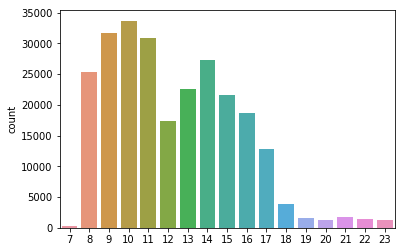

In [36]:
sns.countplot(session_start_time)

Text(0.5, 1.0, 'Alice')

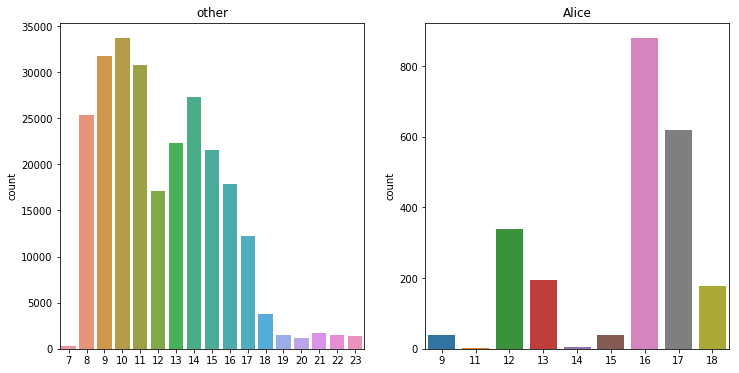

In [51]:
other_start_time = session_start_time[y_train==0]
alice_start_time = session_start_time[y_train==1]
_, ax = plt.subplots(1,2, figsize=(12,6))
sns.countplot(other_start_time,ax=ax[0]).set_title('other')
sns.countplot(alice_start_time,ax=ax[1]).set_title('Alice')
# other people mainly start at morning 
# Alice mainly focus on lunch time and 16-18

In [206]:
# make four categories
morning = ((session_start_time>=7)&(session_start_time<=11)).astype('int')
day = ((session_start_time>=12)&(session_start_time<=18)).astype('int')
evening = ((session_start_time>=19)&(session_start_time<=23)).astype('int')
night = ((session_start_time>=0)&(session_start_time<=6)).astype('int')

scaling_start_hour = session_start_time/24

In [207]:
pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

col_0                           0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

In [208]:
def add_start_time_feature(X_train, X_train_time, add_hour=True):
    session_start_time = X_train_time['time1'].apply(lambda ts: ts.hour)
    morning = ((session_start_time>=7)&(session_start_time<=11)).astype('int').values.reshape(-1,1)
    day = ((session_start_time>=12)&(session_start_time<=18)).astype('int').values.reshape(-1,1)
    evening = ((session_start_time>=19)&(session_start_time<=23)).astype('int').values.reshape(-1,1)
    night = ((session_start_time>=0)&(session_start_time<=6)).astype('int').values.reshape(-1,1)
    # np.hstack make should each array should have same dim
    # practice how to merge certain array together
    all_features = [X_train, morning, day, evening, night]
    time_features = ['morning','day','evening','night']
    if add_hour:
        scaling_start_hour = session_start_time/24
        scaling_start_hour = scaling_start_hour.values.reshape(-1,1)
        all_features.append(scaling_start_hour) # don't use a = [a,b] it will make a sublist 
        time_features.append('start_hour_rescale')
    
    all_features = hstack(all_features)
    return all_features, time_features
    
    

In [261]:
# train new model after adding start time feature
new_train_feat_whour, new_features1= add_start_time_feature(train_session, train_times)
new_test_feat_whour, _ = add_start_time_feature(test_session, test_times)
new_train_feat_nohour, new_features2 = add_start_time_feature(train_session, train_times, False)
new_test_feat_nohour, _ = add_start_time_feature(test_session, test_times, False)


In [262]:
# with hour value
logit_new = LogisticRegression(C=1.0, random_state=17, n_jobs=-1, solver='liblinear', max_iter=100)
cv_add_start_time_feat1 = train_and_predict(logit_new, new_train_feat_whour, y_train, new_test_feat_whour, site_features=tfv.get_feature_names(), new_feature_names=new_features1,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission2.csv')

CV ROC Score->[0.81904687 0.78705941 0.94510729 0.96676436 0.88993687 0.96695898
 mean: 0.9167576893172427, std: 0.06210632157468878


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+7.046,start_hour_rescale
+5.148,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.986,www.express.co.uk
+4.833,youwatch.org
+4.804,www.info-jeunes.net
+4.679,vk.com
+4.567,www.melty.fr
+4.330,fr.glee.wikia.com
+4.100,www.audienceinsights.net
+3.962,www.banque-chalus.fr


In [263]:
pd.DataFrame({'new_feat': new_features1, 'coef': logit_new.coef_[0][-len(new_features1):]})

,new_feat,coef
0,morning,-2.904833
1,day,-0.613841
2,evening,-5.069779
3,night,0.000000
4,start_hour_rescale,7.045650


In [264]:
# without hour value
logit_new = LogisticRegression(C=1.0, random_state=17, n_jobs=-1, solver='liblinear', max_iter=100)
cv_add_start_time_feat2 = train_and_predict(logit_new, new_train_feat_nohour, y_train, new_test_feat_nohour, site_features=tfv.get_feature_names(), new_feature_names=new_features2,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission3.csv')


CV ROC Score->[0.88170019 0.81426901 0.91861247 0.96171465 0.91532998 0.95227476
 mean: 0.9211539394820711, std: 0.04206422641352535


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+5.218,youwatch.org
+5.093,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.971,www.express.co.uk
+4.914,vk.com
+4.640,fr.glee.wikia.com
+4.542,www.info-jeunes.net
+4.382,www.melty.fr
+4.183,www.audienceinsights.net
+4.104,www.banque-chalus.fr
+3.823,r4---sn-gxo5uxg-jqbe.googlevideo.com


In [265]:
pd.DataFrame({'new_feat': new_features2, 'coef': logit_new.coef_[0][-len(new_features2):]})

,new_feat,coef
0,morning,-3.211819
1,day,0.526636
2,evening,-2.721465
3,night,0.000000


In [266]:
# add duration time into feature
durTime_train = (train_times.max(axis=1)-train_times.min(axis=1)).astype('timedelta64[ms]').astype(int).values.reshape(-1,1)
durTime_test = (test_times.max(axis=1)-test_times.min(axis=1)).astype('timedelta64[ms]').astype(int).values.reshape(-1,1)

scaler = StandardScaler()
durTime_train = scaler.fit_transform(durTime_train)
durTime_test = scaler.transform(durTime_test)

new_train_wdur = hstack([new_train_feat_nohour, durTime_train])
new_test_wdur = hstack([new_test_feat_nohour, durTime_test])

if 'duration time' not in new_features2:
    new_features2.append('duration time')

C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [267]:
logit_new = LogisticRegression(C=1.0, random_state=17, n_jobs=-1, solver='liblinear', max_iter=100)
cv_add_start_time_feat3 = train_and_predict(logit_new, new_train_wdur, y_train, new_test_wdur, site_features=tfv.get_feature_names(), new_feature_names=new_features2,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission4.csv')


CV ROC Score->[0.86809822 0.81821883 0.91950143 0.96171682 0.91593618 0.95368912
 mean: 0.9210079641936536, std: 0.042878315707872504


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+5.212,youwatch.org
+5.058,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.974,vk.com
+4.969,www.express.co.uk
+4.617,fr.glee.wikia.com
+4.532,www.info-jeunes.net
+4.363,www.melty.fr
+4.148,www.banque-chalus.fr
+4.146,www.audienceinsights.net
+3.792,r4---sn-gxo5uxg-jqbe.googlevideo.com


In [268]:
cv_add_start_time_feat3>cv_add_start_time_feat2

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])